In [1]:
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap/')
from GalfitPyWrap import galfitwrap as gf
import os

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import fnmatch
%matplotlib inline

# Make plots readable
params = {'legend.fontsize': 14,
	  'figure.figsize': (6,5),
#     'figure.figsize': (6,5),
	 'axes.labelsize': 14,
	 'axes.titlesize':14,
	 'xtick.labelsize':12,
	 'ytick.labelsize':12,
         'image.interpolation':'bilinear'}
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rcParams.update(params)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.linewidth'] = 1.25 #set the value globally
mpl.rcParams['lines.linewidth'] = 0.7

In [38]:
# Make a new f140 file that is in COUNTS not CPS
f140_file = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci.fits'
f140_file_counts = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci_COUNTS.fits'
hdu = fits.open(f140_file)
hdr = hdu[0].header
data = hdu[0].data
exptime = hdr['exptime']
data = data * exptime # convert from CPS to counts
hdu[0].data = data
hdu.writeto(f140_file_counts, clobber=True)

In [54]:
cat_file = '/data/emiln/XLSSU122/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat'
f140_file = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci.fits'
hdulist = fits.open(f140_file)
w = wcs.WCS(hdulist[0].header)
df = pd.read_csv(cat_file,delim_whitespace=True)
df['X'] = w.wcs_world2pix(df['ra'],df['dec'], 1)[0]
df['Y'] = w.wcs_world2pix(df['ra'],df['dec'], 1)[1]
df_members = df[df['member1']>0.5]
print(len(df))
print(len(df_members))
print(df_members.columns.values)
df_members = df_members[df_members['f140_kron']<24]
print(len(df_members))
# df_members['X'] = w.wcs_world2pix(df_members['ra'],df_members['dec'], 1)[0]
# df_members['Y'] = w.wcs_world2pix(df_members['ra'],df_members['dec'], 1)[1]
df_members

1301
54
['phot-id' 'ra' 'dec' 'f105_kron' 'f105_ekron' 'f105_0p8' 'f105_e0p8'
 'f140_kron' 'f140_ekron' 'f140_0p8' 'f140_e0p8' 'asec_fwhm' 'zz' 'zlo'
 'zhi' 'chi' 'spec-id' 'mcode' 'snr' 'em-code' 'member1' 'member2' 'X' 'Y']
29


,phot-id,ra,dec,f105_kron,f105_ekron,f105_0p8,f105_e0p8,f140_kron,f140_ekron,f140_0p8,...,zhi,chi,spec-id,mcode,snr,em-code,member1,member2,X,Y
26,529,34.434215,-3.758796,22.0918,0.0259,23.8068,0.0312,20.6356,0.0102,22.3685,...,1.981394,0.716323,526,1,34.08530,0,1.000000,1.014880e-16,2197.563194,2196.523772
40,455,34.422282,-3.763513,23.1633,0.0304,23.8435,0.0312,21.9504,0.0177,22.5527,...,1.981299,0.695897,451,1,22.31920,0,0.999998,5.068550e-10,2911.998956,1913.498330
53,661,34.434096,-3.757658,23.1297,0.0479,24.2302,0.0389,21.6681,0.0170,22.7377,...,1.987677,0.711522,657,1,18.51870,0,0.999910,6.819980e-11,2204.687898,2264.803766
57,1036,34.432450,-3.749924,23.7272,0.0435,24.1745,0.0375,22.3846,0.0218,22.8474,...,1.982618,0.726539,1032,1,17.43010,0,0.999952,4.399920e-06,2303.236880,2728.843589
59,300,34.435031,-3.767948,24.0850,0.0539,24.3496,0.0423,22.5026,0.0233,22.7896,...,1.989074,0.769476,295,1,16.91640,0,1.000000,1.134630e-22,2148.708598,1647.403784
66,920,34.435628,-3.753143,23.2372,0.0302,23.3537,0.0271,22.7254,0.0254,22.9279,...,1.963658,0.727730,917,1,14.83810,1,0.999974,1.040860e-27,2112.965283,2535.703771
75,305,34.447153,-3.768007,23.8277,0.0513,24.4884,0.0481,22.5249,0.0248,23.0674,...,1.995379,0.874772,298,1,11.84510,0,1.000000,0.000000e+00,1422.960813,1643.858627
76,1057,34.436886,-3.750173,24.1777,0.0524,24.5021,0.0462,22.8479,0.0273,23.1308,...,1.982959,0.735357,1050,1,11.80230,0,0.999931,3.796450e-07,2037.646756,2713.903658
78,1065,34.435917,-3.749538,23.6267,0.0447,24.4200,0.0435,22.3414,0.0220,23.0740,...,1.996971,0.721747,1064,1,11.22480,0,0.960674,2.042080e-02,2095.662219,2752.003758
82,608,34.438450,-3.760699,24.2768,0.0510,24.4365,0.0433,22.9910,0.0285,23.1548,...,1.971139,0.742416,606,1,10.55160,0,0.982975,1.062590e-05,1944.010260,2082.343355


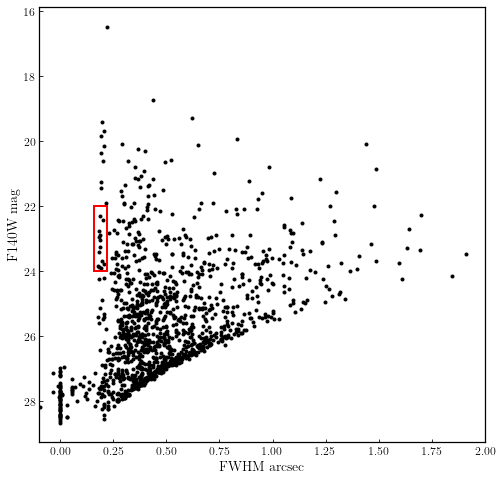

In [57]:
plt.figure(figsize=(8,8))
plt.scatter(df['asec_fwhm'],df['f140_kron'],marker='.',c='k',facecolors='none')
plt.gca().invert_yaxis()
plt.xlim(-0.1,2)
plt.ylabel('F140W mag')
plt.xlabel('FWHM arcsec')
lw=2
l=0.16
r=0.22
t=24
b=22
# b=16
plt.plot([l,r],[t,t],color='r',linewidth=lw)
plt.plot([l,r],[b,b],color='r',linewidth=lw)
plt.plot([l,l],[b,t],color='r',linewidth=lw)
plt.plot([r,r],[b,t],color='r',linewidth=lw)
# plt.grid()

In [58]:
stardf = df[(df['asec_fwhm']>l) & (df['asec_fwhm']<r) & (df['f140_kron']>b) & (df['f140_kron']<t)]
print(len(stardf))
stardf

13


,phot-id,ra,dec,f105_kron,f105_ekron,f105_0p8,f105_e0p8,f140_kron,f140_ekron,f140_0p8,...,zhi,chi,spec-id,mcode,snr,em-code,member1,member2,X,Y
36,263,34.440087,-3.769243,22.3995,0.0144,22.4437,0.0142,22.3104,0.0200,22.3441,...,3.944814,0.936046,260,1,25.93030,0,0.0,0.0,1846.004803,1569.702857
65,324,34.442398,-3.767419,23.0132,0.0207,23.0463,0.0202,22.8837,0.0265,22.9110,...,1.167043,0.821059,323,1,15.01080,0,0.0,0.0,1707.643795,1679.141853
72,681,34.447052,-3.759426,23.0208,0.0203,23.0551,0.0198,23.0455,0.0289,23.0761,...,1.632723,0.829760,679,1,12.27250,0,0.0,0.0,1429.000552,2158.718726
81,271,34.451130,-3.769146,99.0000,99.0000,99.0000,99.0000,22.4213,0.0311,22.4610,...,0.279714,1.198478,270,1,10.57490,0,0.0,0.0,1184.857886,1575.514732
94,129,34.445913,-3.773490,22.9813,0.0208,23.0204,0.0205,22.7659,0.0296,22.7949,...,4.090478,1.004269,128,1,9.03701,0,0.0,0.0,1497.204135,1314.879598
113,208,34.450807,-3.771243,99.0000,99.0000,99.0000,99.0000,22.9406,0.0598,22.9573,...,3.375060,1.256374,208,1,7.53402,0,0.0,0.0,1204.198260,1449.695079
133,1314,34.445923,-3.741057,23.9604,99.0000,23.9695,99.0000,23.6830,0.0804,23.7033,...,1.727327,0.794361,1310,1,6.25858,0,0.0,0.0,1496.580881,3260.859681
138,655,34.449669,-3.760053,23.8726,0.0330,23.9149,0.0322,23.8456,0.0441,23.8716,...,1.816876,0.865616,652,1,5.92479,0,0.0,0.0,1272.319063,2121.096311
140,520,34.446577,-3.762933,23.6701,0.0293,23.7120,0.0288,23.7849,0.0425,23.8045,...,0.265228,0.813217,518,1,5.90241,0,0.0,0.0,1457.442038,1948.299110
141,244,34.429961,-3.770356,24.0358,0.0369,24.0478,0.0352,23.9032,0.0444,23.9156,...,1.853760,0.740867,242,1,5.86582,0,0.0,0.0,2452.250223,1502.922943


10833.52331054691
6790.979895996367
6049.483815918047
9898.516441406275
8261.376899414066
6606.561625976586
3737.0533557129684
2843.7707749023944
2992.5455642090155
2978.0179538574894
5031.775413086012
4437.7477148440385
2769.180257812569


/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/emiln/.local/lib

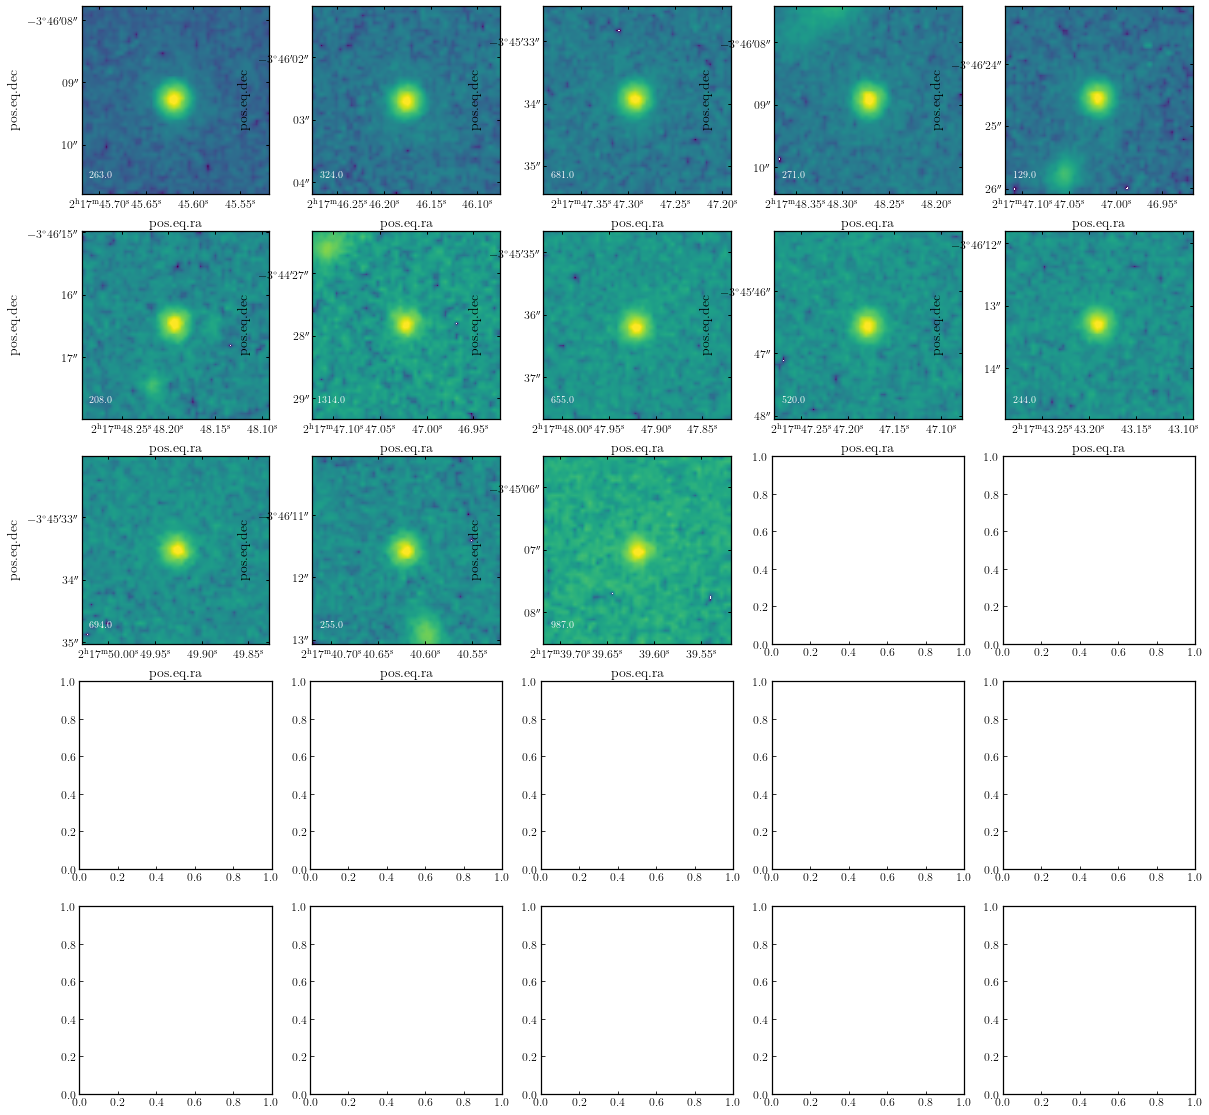

In [75]:
# Print cutouts of stars
# imgfits = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci.fits'
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from astropy.visualization import simple_norm
imgfits = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci_COUNTS.fits'
f = fits.open(imgfits)
w = wcs.WCS(f[0].header)
cutoutsize = 3
size = u.Quantity((cutoutsize, cutoutsize), u.arcsec)
plt.subplots(5,5,figsize=(20,20))

i=0
for r in stardf.iterrows():
    i+=1
    r = r[1]
    ra = r.ra
    dec = r.dec
    position = SkyCoord(ra=ra*u.degree,dec=dec*u.degree)
    cutout = Cutout2D(f[0].data, position, size, wcs=w)
    vmin = np.percentile(cutout.data,0.1)
    vmax = np.percentile(cutout.data,99.9)
    print(vmax)
    plt.subplot(5,5,i,projection=cutout.wcs)
    norm = simple_norm(cutout.data, 'log', percent=99.)
    plt.imshow(cutout.data,vmin=vmin,vmax=vmax,norm=norm)
#     plt.imshow(cutout.data,vmin=vmin,vmax=vmax)
#     plt.imshow(cutout.data,norm=LogNorm(vmin=1e-10,vmax=vmax))
#     plt.imshow(cutout.data,norm=SymLogNorm(1e2,vmin=vmin,vmax=vmax))
    plt.text(0.1, 0.1,r['phot-id'],color='white',
     horizontalalignment='center',
     verticalalignment='center',
     transform = plt.gca().transAxes)
#     plt.show()

In [43]:
# Remove star 1128, 1170
# removestars = [1128,1170]
removestars = [1128,1170,255,1314,208,129,271]
stardf = stardf[~stardf['phot-id'].isin(removestars)]
stardf

,phot-id,ra,dec,f105_kron,f105_ekron,f105_0p8,f105_e0p8,f140_kron,f140_ekron,f140_0p8,...,zhi,chi,spec-id,mcode,snr,em-code,member1,member2,X,Y
36,263,34.440087,-3.769243,22.3995,0.0144,22.4437,0.0142,22.3104,0.0200,22.3441,...,3.944814,0.936046,260,1,25.93030,0,0.0,0.0,1846.004803,1569.702857
65,324,34.442398,-3.767419,23.0132,0.0207,23.0463,0.0202,22.8837,0.0265,22.9110,...,1.167043,0.821059,323,1,15.01080,0,0.0,0.0,1707.643795,1679.141853
72,681,34.447052,-3.759426,23.0208,0.0203,23.0551,0.0198,23.0455,0.0289,23.0761,...,1.632723,0.829760,679,1,12.27250,0,0.0,0.0,1429.000552,2158.718726
138,655,34.449669,-3.760053,23.8726,0.0330,23.9149,0.0322,23.8456,0.0441,23.8716,...,1.816876,0.865616,652,1,5.92479,0,0.0,0.0,1272.319063,2121.096311
140,520,34.446577,-3.762933,23.6701,0.0293,23.7120,0.0288,23.7849,0.0425,23.8045,...,0.265228,0.813217,518,1,5.90241,0,0.0,0.0,1457.442038,1948.299110
141,244,34.429961,-3.770356,24.0358,0.0369,24.0478,0.0352,23.9032,0.0444,23.9156,...,1.853760,0.740867,242,1,5.86582,0,0.0,0.0,2452.250223,1502.922943
146,694,34.458029,-3.759311,99.0000,99.0000,99.0000,99.0000,23.2591,0.0498,23.2747,...,1.225640,0.952275,691,1,5.71930,0,0.0,0.0,771.797557,2165.605457
245,987,34.415070,-3.751951,99.0000,99.0000,99.0000,99.0000,23.8793,0.0892,23.8946,...,2.262443,0.722545,986,1,3.20794,0,0.0,0.0,3343.801558,2607.210351


In [44]:
# Building PSF from these stars
# https://photutils.readthedocs.io/en/stable/epsf.html
# Follows https://arxiv.org/pdf/astro-ph/0006325.pdf
#### REQUIRES PYTHON 3.5+ ###
from photutils import datasets
from astropy.table import Table
from astropy.nddata import NDData

In [45]:
stars_tbl = Table()
stars_tbl['x'] = stardf['X']
stars_tbl['y'] = stardf['Y']
data = f[0].data

In [46]:
from astropy.stats import sigma_clipped_stats
# Subtract background (not necessary for us)
# mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
# data -= median_val  
data = data.clip(min=0) # set negative values to zero

In [47]:
print(np.shape(data))
nddata = NDData(data=data)
print(nddata)

(4312, 4313)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=50)
print(stars)

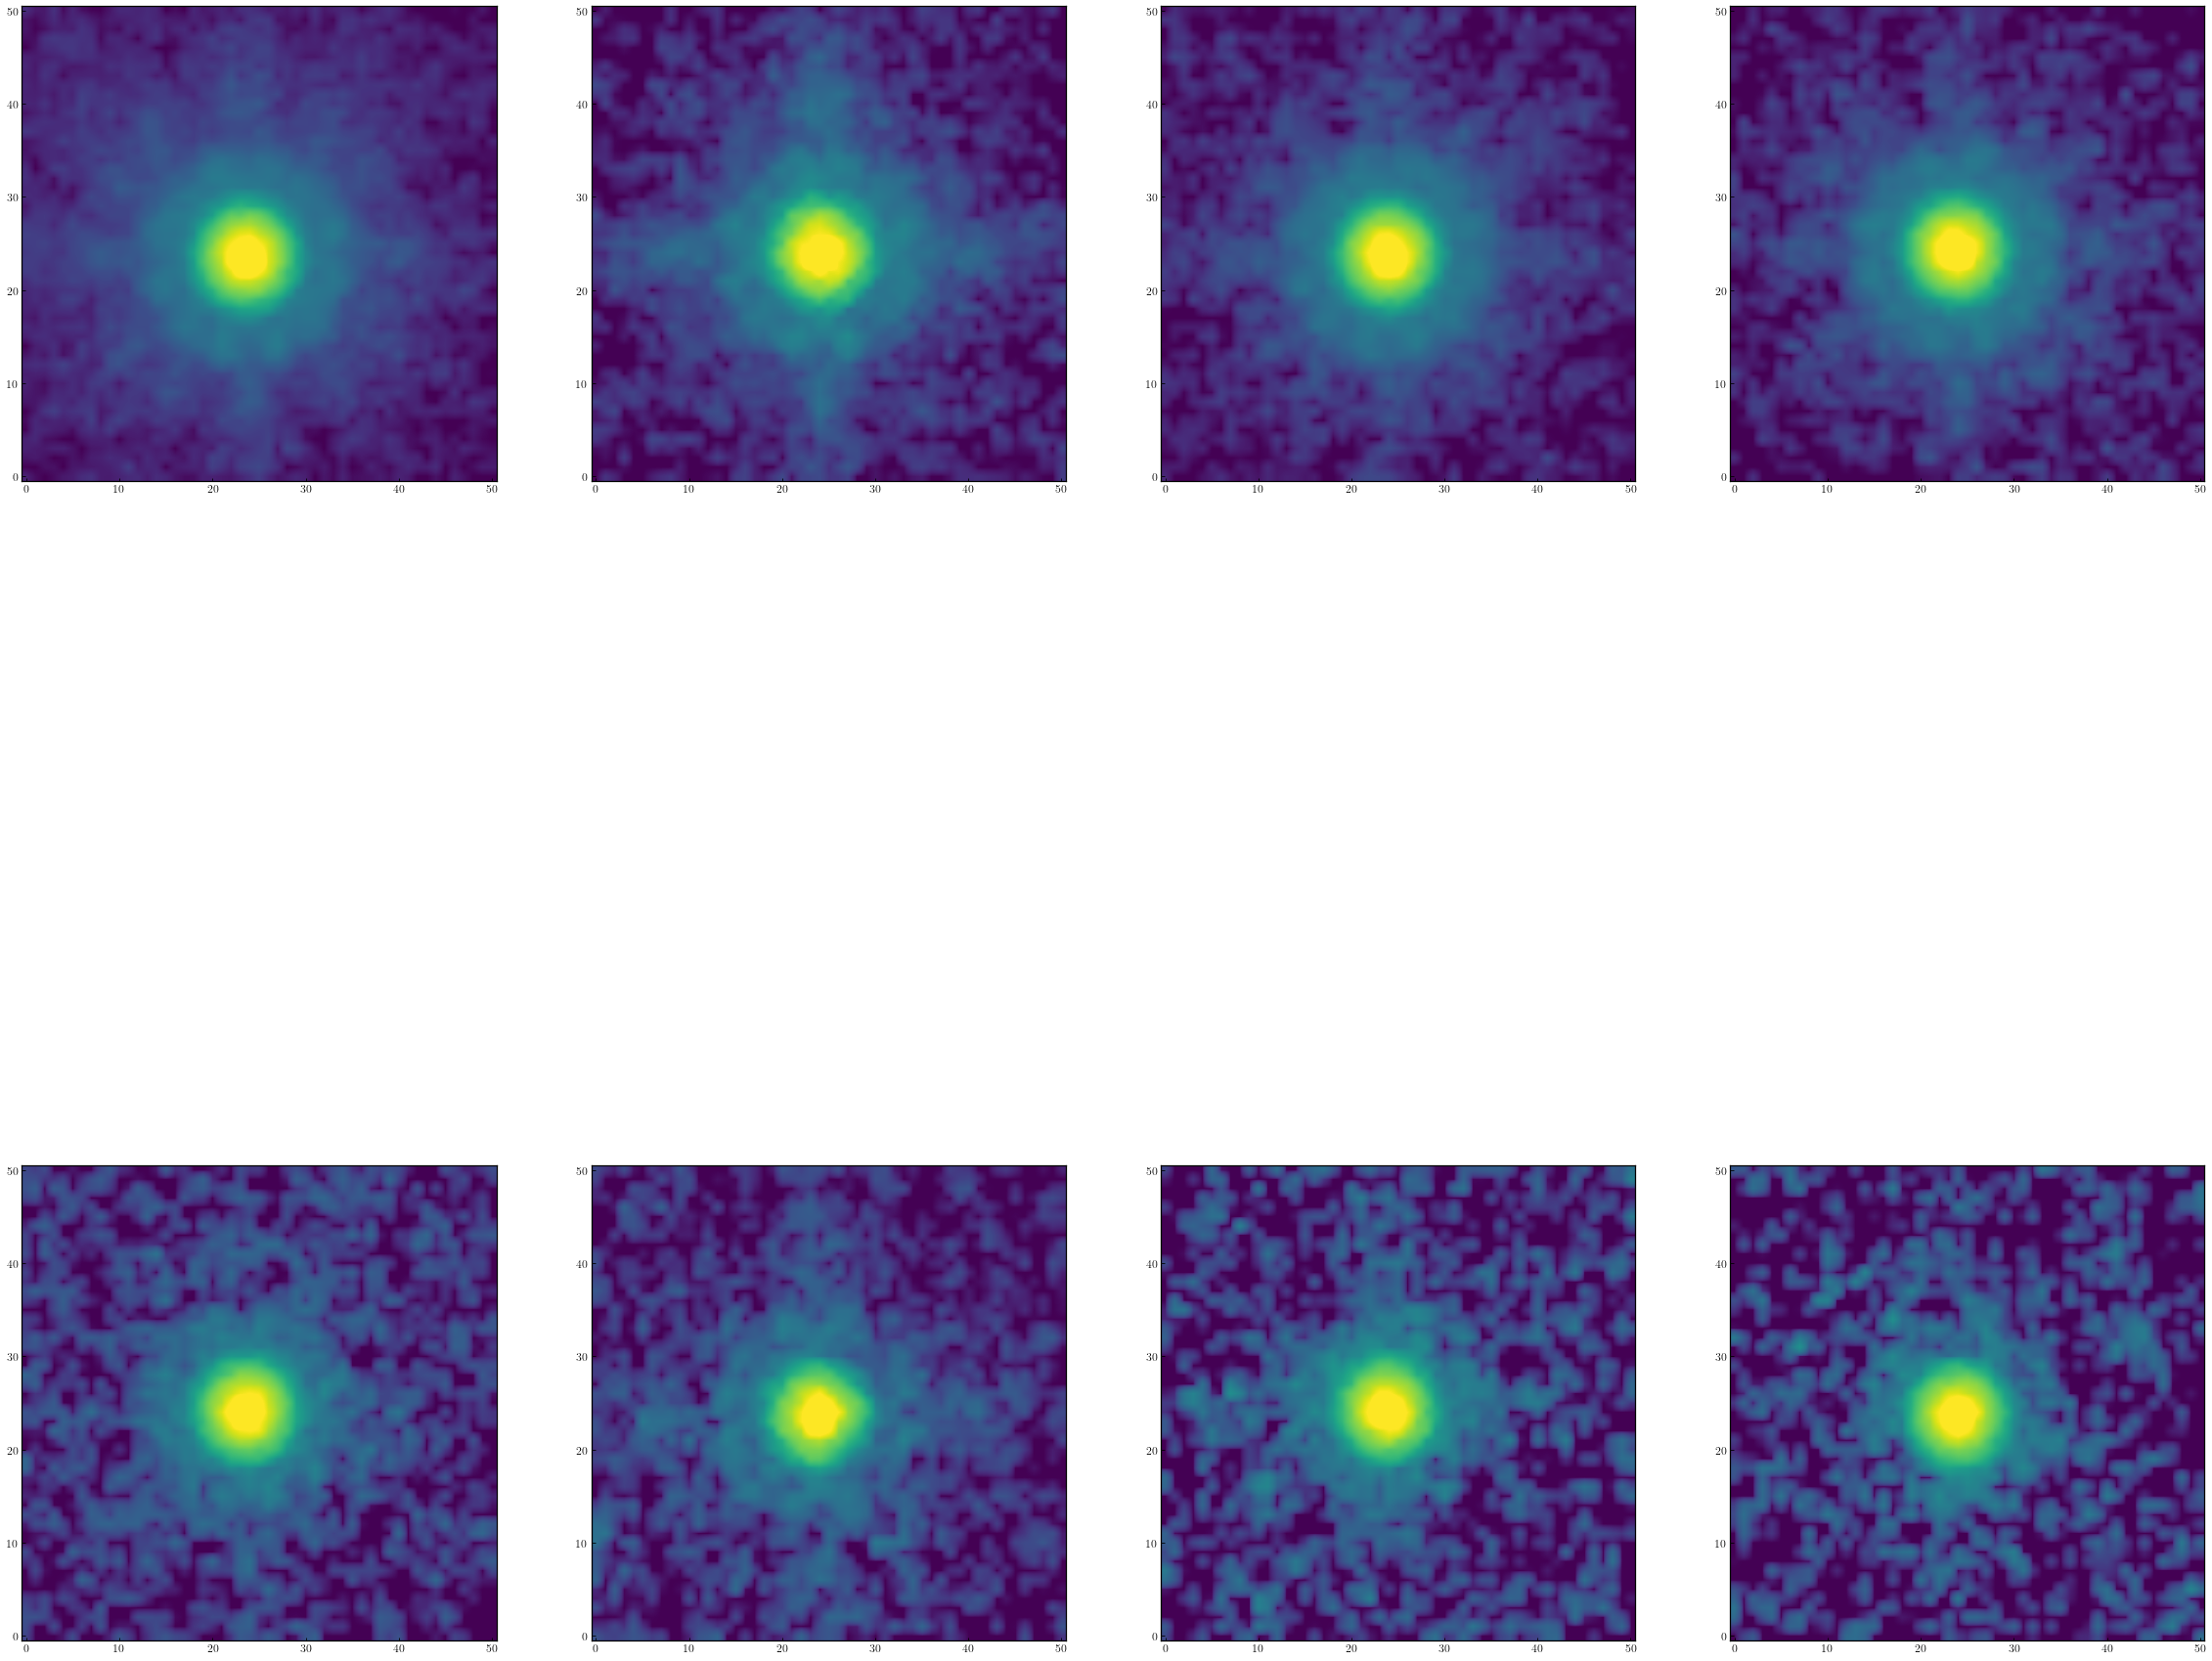

In [48]:
from astropy.visualization import simple_norm
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 40),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [84]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=2, maxiters=1,
                           progress_bar=False)   
# epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
#                            progress_bar=False, smoothing_kernel=None)   
epsf, fitted_stars = epsf_builder(stars)  

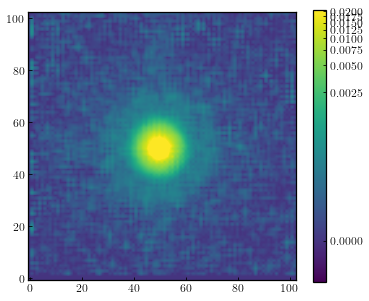

In [86]:
norm = simple_norm(epsf.data, 'log', percent=99.)
epsfdata = epsf.data.clip(min=0)
# plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.imshow(epsfdata, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

------------------------
Try making PSF manually by oversampling original cutouts, center them on the brightest pixel and then stack.

In [87]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

In [89]:
# Fit 2D Gaussian to extract location of centroid
x1, y1 = centroid_2dg(epsfdata)
print((x1, y1)) 

(49.91399803864328, 50.07917143188853)


In [91]:
stars[0].data

array([[52.757313 , 16.90091  ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.9843767,  0.       , 22.339815 , ..., 17.949282 , 45.1316   ,
        43.326935 ],
       [28.773863 , 40.1602   , 23.603085 , ...,  0.       ,  9.966784 ,
        31.795668 ],
       ...,
       [30.112299 ,  3.7812111, 18.452143 , ..., 22.188892 , 44.719524 ,
        45.423462 ],
       [26.440844 ,  9.440885 , 37.229828 , ..., 33.543934 ,  0.       ,
         0.       ],
       [86.07062  , 38.281853 , 35.57056  , ...,  7.2159405, 32.872124 ,
         0.       ]], dtype=float32)

In [94]:
# Find index of max value
tdata = stars[0].data
max_idx = np.argmax(tdata)
np.unravel_index(max_idx,tdata.shape)

(23, 24)